# Exchange Rate Models and Exchange Rate Forecast

Prepared for the Winter Camp of Quantitative Economics@PHBS by Jiao Shi

### Today's Lecture
** Exchange rate models (In the PDF slides)**
  * Introduction to exchange rate
  * Foreign exchange market
  * Goods market-based models of exchange rate
  * Asset market-based models of exchange rate

**Exchange rate forecast (In this Jupyter notebook)**
  * Out-of-sample forecast
  * Data
  * An illustrative example: RMB/USD exchange rate

### Key tools and concepts that we use in this notebook
  * Data visualization and analysis
  * Linear regression
  * Rolling-window regression and forecast
  * In-sample fit and out-of-sample forecast
  * Evaluating forecasting power of models

## Exchange rate models

We considered several exchange rate models based on economic fundamentals.

Specifically, we derive these linearized model:

1. The PPP-based model
$$ s_{t}=\alpha+\beta(p_{t}-p_{t}^{*})+\epsilon_{t} $$

2. The flexible-price monetary model:
$$ s_{t}=\eta(i_{t}-i_{t}^{*})-\phi(y_{t}-y_{t}^{*})+(m_{t}-m_{t}^{*}) $$

3. The UIP-based model
$$ E_{t}(s_{t+1}-s_{t})=\alpha+\beta(i_{t}-i_{t}^{*}) $$

4. The Taylor-rule model
$$ E_{t}(s_{t+1}-s_{t})=\alpha+\beta(\pi_{t}-\pi_{t}^{*})+\beta_{2}(\tilde{y}_{t}-\tilde{y}_{t}^{*}) $$

Each model offers a set of **macroeconomic fundamentals** that determines the exchange rate. How do we know how good the models are? We examine the model using data.

A straightfoward way to do so is to run regressions of the exchange rate on the macro fundamentals, and examine how much variation in the exchange rate can be explained by the fundamentals. This is a check of the model's fitness **in sample**.

The golden rule of the literature, however, is **out-of-sample forecast**, which stems from the siminal work of Meese and Rogoff (1983).

> Meese and Rogoff(1983) shows that none of existing exchange rate models based on macroeconomic fundamentals can consistently beats the random walk model in out-of-sample forecast.

Meese and Rogoff (1983) also set the convention of using the **random walk without drift** model of exchange rate as the benchmark model. 

The random walk model says that the best predictor of exchange rate tomorrow is the exchange rate today:

$$ E_ts_{t+1} - s_t = 0 $$

## A look at data

Here's a summary of data and their sources:

|        Data       | Source | Notes     | 
| -------------------------| ------------- | --------- | 
|CNY/USD exchange rate   | People's Bank of China | End-of-period value  | 
|Nominal interest rates   | IMF's International Financial Statistics  | Yields on 3-month, 1-year and 5-year government bonds |  
|Money supply   | People's Bank of China & Federal Reserve  | M1&M2 |
|GDP   | Bueareu of Statistics (China), ISM (US)  | PMI indices used as proxy |
|Real exchange rate   | Bank of International Settlement  | Trade-weighted real effective exchange rate |


Matplotlib and Pandas are useful for our purpose in this section.

Data can be loaded by using Panda's read_csv function directly from QuantEcon's Winter Camp repository.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [12]:
er = pd.read_csv('https://github.com/QuantEcon/ShenzhenWinterCamp/raw/master/Jiao%20Shi/ExR.csv')
type(er)

pandas.core.frame.DataFrame

A brief look at the data tells us that there are 275 monthly obervations, ranging from January 1995 to December of 2017.

In [5]:
er.describe()

,CNYUSD
count,276.000000
mean,7.473064
std,0.869356
min,6.096900
25%,6.629075
50%,7.984400
75%,8.277725
max,8.438500


In [6]:
er

,Date,CNYUSD
0,1995-01,8.4385
1,1995-02,8.4310
2,1995-03,8.4265
3,1995-04,8.4077
4,1995-05,8.3065
5,1995-06,8.3020
6,1995-07,8.3003
7,1995-08,8.3200
8,1995-09,8.3190
9,1995-10,8.3147


A more intuitive way to "see" the data is to plot the series in a graph.

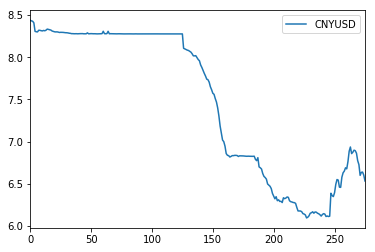

In [36]:
er.plot()
plt.show()

**In-class exercise:** How do we put date on the x-axis?

What do you see in this plot? Does anything appear strange?

A brief history of the Renminbi exchange rate regime.

The Renminbi exchange rate was fixed against the US dollar, with several revaluations in history, until...?

As there were little variability for us to explore (and, clearly, no room for the exchange rate to be moved by economic fundamentals) before the exchange rate reform, we will focus on the "managed floating era" by using data after July 2005.

In [14]:
erf = pd.read_csv('https://github.com/QuantEcon/ShenzhenWinterCamp/raw/master/Jiao%20Shi/ER_predict.csv')
erf

,Date,CNYUSD,RMB_REER,CHN PMI,USA PMI,CHN M1,USA M1,CHN M2,USA M2,CHN CPI inflation,USA CPI inflation,CHN_IBR,US_FFR
0,2005-07,8.1062,85.01,51.1,52.8,"97,700.00","1,365.00","277,000.00","6,498.40",1.80,3.2,1.1395,3.36
1,2005-08,8.0998,85.05,52.6,52.4,"99,400.00","1,376.50","281,300.00","6,522.50",1.30,3.6,1.1774,3.30
2,2005-09,8.0920,85.29,55.1,56.8,"101,000.00","1,363.10","287,000.00","6,555.00",0.90,4.7,1.1675,3.57
3,2005-10,8.0845,86.39,54.1,57.2,"101,800.00","1,365.10","287,600.00","6,582.30",1.20,4.3,1.2442,3.73
4,2005-11,8.0804,87.75,54.1,56.7,"104,100.00","1,373.20","292,400.00","6,623.00",1.30,3.5,1.2049,3.99
5,2005-12,8.0702,87.59,54.3,55.1,"107,300.00","1,396.90","298,800.00","6,676.30",1.60,3.4,1.4696,4.03
6,2006-01,8.0608,86.88,52.1,55.0,"107,400.00","1,375.20","303,500.00","6,674.40",1.90,4.0,1.4242,4.22
7,2006-02,8.0415,88.13,52.1,55.8,"104,400.00","1,361.70","304,500.00","6,691.80",0.90,3.6,1.3620,4.51
8,2006-03,8.0170,86.90,55.3,54.3,"107,000.00","1,394.40","310,500.00","6,764.30",0.80,3.4,1.3454,4.52
9,2006-04,8.0165,85.98,58.1,55.2,"106,400.00","1,393.30","313,700.00","6,827.60",1.20,3.5,1.5297,4.87


## Regression: testing the UIP (interest differential) model

The UIP model tells us that the expected change in the exchange rate is determined by the interest differential. 

Here we regress the change in exchange rate on the fundamentals.

This is an *estimation* of our exchange rate model. Later, we will use estimated model to make a *forecast* of the change in the exchange rate one period ahead.

**First we add several columns to the dataframe to create series of dependent and independent variables.**

Our dependent variable is not the *level* of exchange rate but *change* in the exchange rate.

In [15]:
# compute the change in the exchange rate: take log and first difference to compute depreciation (dep)
erf['lner'] = np.log(erf[['CNYUSD']])
erf['dep'] = 100*erf['lner'].diff(periods = 1)

In [16]:
# Create a new column to reindex depreciation - why?
erf['dep_1'] = 0
size_sample = 149

for i in range(size_sample):
    erf.loc[i,'dep_1'] = erf.loc[i+1,'dep']
erf.loc[size_sample,'dep_1'] = erf.loc[0,'dep']

Next we compute the independent variable: interest differential across US and China.

In [17]:
erf['int_diff'] = erf['CHN_IBR'] - erf['US_FFR']

Let's see if exchange rate depreciation is correlated with the interest differential by plotting them in a graph

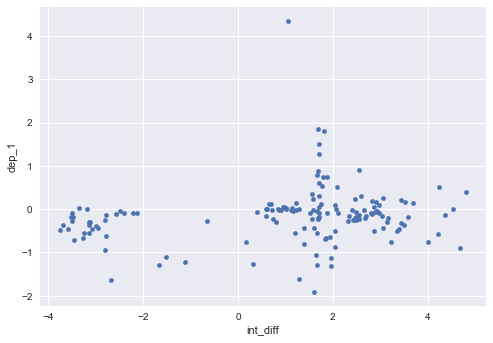

In [18]:
plt.style.use('seaborn')

erf.plot(x='int_diff', y='dep_1', kind='scatter')
plt.show()

The relationship does not appear clear from a glance at the data.

Let's do the regression.

In [19]:
erf['const'] = 1 # create column of constant

reg_int = sm.OLS(endog=erf['dep_1'], exog=erf[['const', 'int_diff']], missing='drop')
results = reg_int.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  dep_1   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.998
Date:                Thu, 01 Feb 2018   Prob (F-statistic):             0.0269
Time:                        11:53:21   Log-Likelihood:                -148.45
No. Observations:                 149   AIC:                             300.9
Df Residuals:                     147   BIC:                             306.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1985      0.059     -3.355      0.0

** Interpretation of the Results **:
1. Do the sign and the magnitude of the parameters fit your intuition?
2. How much variations in the exchange rate can interest rate differential account for?

> **In-class exercise:** Run the regression of the Taylor-rule model and interpret the results. Are the signs and magnitude of the coefficients consistent with theory? Does the Taylor-rule model has better in-sample explanatory power than the UIP model?

## Rolling-window regressions and forecasts

Next we move to **out-of-sample** forecast. We use the **rolling window forecasting**, which means that we re-estimate parameters of the model using a window of recent data before using the estimated model to make a forecast of the exchange rate.

Regarding the size of the estimation sample, we face a trade-off:
* Shorter estimation window allows parameters to adapt more quickly to structural change
* Longer estimation window allows more efficient estimation of the parameters

Here's how we proceed:
1. We use 60 periods (5 years) of data to train the model.

2. Then we use the estimated model to make *one* single prediction on the change in exchange rate in the next period.

3. We examine how good the forecast is by checking how far away the forecast is from the realized (actual) value of exchange rate depreciation.



### An illustrative single regression

First let's do a single regression to illustrate the idea, using the UIP model as the starting point.

In [20]:
# regression with 60 data points and make a forecast on exchange rate in period 61

# Regression with the first subsample
size_subsample = 60

reg_intsub = sm.OLS(endog=erf.loc[0:size_subsample - 1,'dep_1'], exog=erf.loc[erf.index[0:size_subsample],['const', 'int_diff']], missing='drop')
results_sub = reg_intsub.fit()
print(results_sub.summary())


                            OLS Regression Results                            
Dep. Variable:                  dep_1   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     8.054
Date:                Thu, 01 Feb 2018   Prob (F-statistic):            0.00625
Time:                        12:00:07   Log-Likelihood:                -24.877
No. Observations:                  60   AIC:                             53.75
Df Residuals:                      58   BIC:                             57.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2226      0.055     -4.039      0.0

In [54]:
# Make a forecast and compute forecast error
error = results_sub.predict(exog = [1, erf.loc[60,'int_diff']]) - erf.loc[60, 'dep_1']
error

array([-0.60304797])

### The rolling-window regression and forecasts



In [21]:
# Now we do it recursively
size_sample = 149
size_subsample = 60

# How many regressions can we run? How many forecast errors can we compute?
fcst_error_int = np.zeros(size_sample - size_subsample)
for i in range (size_sample - size_subsample):
    reg_intsub = sm.OLS(endog=erf.loc[i:size_subsample-1+i,'dep_1'], exog=erf.loc[erf.index[i:size_subsample+i],['const', 'int_diff']], missing='drop')
    results_sub = reg_intsub.fit()
    error = results_sub.predict(exog = [1, erf.loc[size_subsample+i,'int_diff']]) - erf.loc[size_subsample+i, 'dep_1']
    fcst_error_int[i] = error
    
fcst_error_int


array([ -6.03047966e-01,   1.51083664e+00,   5.57896386e-02,
         6.56219475e-02,   6.37607069e-01,   3.61449877e-01,
         8.86266893e-02,   1.91292205e-01,   7.05824529e-01,
         4.52660067e-03,   3.58457592e-02,   3.03892794e-01,
         8.81193620e-01,   3.07847358e-01,   3.21433537e-01,
        -5.02365855e-01,   5.82336362e-01,  -3.76417628e-01,
         1.53376696e-01,  -2.35806230e-01,   3.21752360e-02,
        -1.10211390e+00,   9.65425141e-03,  -3.55746873e-01,
        -2.70614868e-01,  -8.30902236e-02,   4.35713639e-01,
         1.79865897e-01,  -4.00024530e-02,  -1.01304056e-01,
        -1.50434637e-01,  -2.86282568e-02,   6.01641476e-01,
         4.68346583e-01,  -1.97876409e-01,  -3.03293611e-01,
        -1.40875051e-01,   1.49347081e-01,  -1.17518656e-01,
        -4.37213140e-02,   3.36139474e-01,  -3.81699089e-01,
        -4.80130435e-01,  -7.29251485e-01,  -2.70410203e-01,
        -3.59630143e-01,   1.00242488e-01,  -4.13474804e-01,
        -1.18771445e-01,

Now we do the same to obtain forecast errors made by the Taylor-rule model:

In [23]:
# Taylor-Rule model

# inflation differential
erf['pi_diff'] = erf['CHN CPI inflation'] - erf['USA CPI inflation']

fcst_error_tr = np.zeros(size_sample - size_subsample)
for i in range (size_sample - size_subsample):
    # Create a column to store the output gap difference and update it in each loop
    y_chn = erf['CHN PMI'] - np.mean(erf.loc[i:size_subsample-1+i, 'CHN PMI'])
    y_us = erf['USA PMI'] - np.mean(erf.loc[i:size_subsample-1+i, 'USA PMI'])
    erf['y_diff'] = y_chn - y_us
    
    reg_trsub = sm.OLS(endog=erf.loc[i:size_subsample-1+i,'dep_1'], exog=erf.loc[erf.index[i:size_subsample+i],['const', 'pi_diff','y_diff']], missing='drop')
    results_sub = reg_trsub.fit()
    
    # error = results_sub.predict(exog = [1, erf.loc[size_subsample+i,'int_diff']]) - erf.loc[size_subsample+i, 'dep_1']
    
    error = results_sub.predict(exog = [erf.loc[size_subsample+i,['const', 'pi_diff','y_diff']]]) - erf.loc[size_subsample+i, 'dep_1']
    fcst_error_tr[i] = error
    
fcst_error_tr

array([ -1.05095393e+00,   1.16143051e+00,  -4.16715632e-01,
        -4.04337393e-01,   1.29924580e-01,  -8.38052344e-02,
        -3.97134600e-01,  -2.34109735e-01,   3.97747782e-01,
        -2.22560594e-01,  -2.30657672e-01,  -7.00384452e-02,
         3.68940775e-01,   2.21812553e-02,   4.87509038e-02,
        -8.16626142e-01,   5.56689743e-01,  -4.15553725e-01,
        -1.31036170e-02,  -1.47620344e-01,   2.54748589e-02,
        -1.15024160e+00,  -6.34728029e-02,  -2.12200638e-01,
        -2.79467162e-01,   2.54705307e-02,   6.95453414e-01,
         2.59444741e-01,  -1.56460469e-02,  -7.15394555e-02,
        -6.72710502e-02,  -6.40390355e-02,   6.55060213e-01,
         4.39055876e-01,  -1.34530275e-01,  -1.83583428e-01,
        -4.70352714e-02,   1.50251573e-01,  -2.09556604e-01,
        -1.68967373e-01,   2.94103820e-01,  -3.44601385e-01,
        -4.36920665e-01,  -6.59894816e-01,  -2.43987467e-01,
        -2.07936013e-01,   1.85981205e-01,  -3.22188032e-01,
        -4.49700997e-02,

In [24]:
# compute RMSE for the interest differential model
rmse_int = np.sqrt(np.mean(fcst_error_int**2))
rmse_int

0.80592948629223393

In [25]:
# Compute RMSE for the Taylor rule model
rmse_tr = np.sqrt(np.mean(fcst_error_tr**2))
rmse_tr

0.7710978433653588

What's the forecast errors of the random walk model?

In [26]:
# compute RMSE for the random walk model
rmse_rw = np.sqrt(np.mean(erf.loc[size_subsample: size_sample-1, 'dep_1']**2))
rmse_rw

0.78435646614511745

Judging by the RMSE, which model is the best? Do the macro fundamentals-based models "beat" the random walk model?

### Futher Reading: Evaluating Model's Predictive Power

We compared the root mean squared error (RMSE) produced by each model.

How do we know if one model *significantly* outperforms another in forecasting? We use test statistics. Two commonly used tests in the literature are:

* Diebold and Mariano (1995) and West (1996) test (henceforth DMW test)
* Clark and West (2006) test (henceforth CW test)

The DMW test is used for non-nested competing models, and the CW test is used for nested models.
> "Nested" means one model can be written as a special case of another model.
> For example, the random walk model is a special case of the models based on economic fundamentals. Why?

### Discussion: How important is forecastability?

### Further Reading: Are Exchange Rate *Supposed to be* Forecastable?

### References

Clark, T. E., & West, K. D. (2007). Approximately normal tests for equal predictive accuracy in nested models. Journal of econometrics, 138(1), 291-311.

Diebold, Francis X., and Robert S. Mariano. "Comparing predictive accuracy." Journal of Business & economic statistics 20.1 (2002): 134-144.

Meese, R. A., & Rogoff, K. (1983). Empirical exchange rate models of the seventies: Do they fit out of sample?. Journal of international economics, 14(1-2), 3-24.

Rossi, B. (2013). Exchange rate predictability. Journal of economic literature, 51(4), 1063-1119.

West, K. D. (1996). Asymptotic inference about predictive ability. Econometrica: Journal of the Econometric Society, 1067-1084.